# Analysing BOM Solar Exposure Data


This notebook imports, rearranges and plots solar exposure data provided by the BOM. The data is collected from the BOM website as a csv file, and consists of daily global solar exposure data. This is the total amount of solar energy hitting the surface of the ground at a weather station over a 24 hour period, in MegaJoules per square metre. More information can be found [here](http://www.bom.gov.au/climate/austmaps/solar-radiation-glossary.shtml#globalexposure).

The aim is to bring the data in, reformat it using Pandas DataFrames, and mathematically model the change in solar exposure throughout the year using SciPy.

## Read in the file, format the data
We will read in the file using the pandas method read_csv, which will automatically create a DataFrame with the csv headers as column names.

In [1]:
# Import modules
from math import ceil
import pandas # DataFrames
import matplotlib.pyplot as plt # Plotting
from scipy.optimize import curve_fit # Nonlinear regression
import numpy as np # Arrays
# Show plots inline in the notebook
%matplotlib inline

# Read in the csv file
csv_name = 'Brisbane-Daily.csv'
df = pandas.read_csv(csv_name)
df.head()

,Product code,Bureau of Meteorology station number,Year,Month,Day,Daily global solar exposure (MJ/m*m)
0,IDCJAC0016,40913,1990,1,1,32.6
1,IDCJAC0016,40913,1990,1,2,33.5
2,IDCJAC0016,40913,1990,1,3,NaN
3,IDCJAC0016,40913,1990,1,4,33.2
4,IDCJAC0016,40913,1990,1,5,24.0


We have successfully ingested the data. We need to remove the first two columns, as they are irrelevant to us.

In [2]:
# Remove the 'Product Code' and 'Station Number' columns
df.drop(df.columns[[0,1]], axis=1, inplace=True)
# Shorten the name of the last column
df.rename(columns={df.columns[-1]:'MJsqm'}, inplace=True)
df.head()

,Year,Month,Day,MJsqm
0,1990,1,1,32.6
1,1990,1,2,33.5
2,1990,1,3,NaN
3,1990,1,4,33.2
4,1990,1,5,24.0


We now need to pad the month and day columns, to make them equal width. This is because we will concatenate the month and day later, pre-empting a table pviot on year. Padding can be done easily with zfill(), a string method designed to pad with zeros.

In [3]:
# Pad the months and days with zeros to make them all 2 chars wide
df['Month'] = df['Month'].apply(lambda x : str(x).zfill(2))
df['Day'] = df['Day'].apply(lambda x : str(x).zfill(2))
df.head()

,Year,Month,Day,MJsqm
0,1990,01,01,32.6
1,1990,01,02,33.5
2,1990,01,03,NaN
3,1990,01,04,33.2
4,1990,01,05,24.0


We now concatenate the month and day using string formatting. There should be 366 unique values in the 'Mon-Day' column.

In [4]:
# Create a DateTime column - the concat of month and day
df['Mon-Day'] = df[['Month','Day']].apply(lambda x : '{}-{}'.format(x[0], x[1]), axis=1)
df.head()

,Year,Month,Day,MJsqm,Mon-Day
0,1990,01,01,32.6,01-01
1,1990,01,02,33.5,01-02
2,1990,01,03,NaN,01-03
3,1990,01,04,33.2,01-04
4,1990,01,05,24.0,01-05


## Pivot the table on year
We will pivot based on year, to get one column per year, with one row for each day of the year. This will allow us to easily compute statistics over each row. Pandas DataFrames have a very easy to use pivot method.

In [5]:
# Pivot the table to have years as columns
byYear = df.pivot(index='Mon-Day', columns='Year', values='MJsqm')
byYear.head()

Year,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
Mon-Day,,,,,,,,,,,,,,,,,,,,,
01-01,32.6,NaN,18.3,32.8,32.8,27.7,24.6,NaN,NaN,NaN,...,20.8,26.3,18.6,9.3,30.9,27.6,31.2,23.4,25.5,31.1
01-02,33.5,23.7,30.1,31.6,31.9,29.3,23.9,11.1,23.1,0.8,...,21.4,9.2,22.8,27.2,31.1,32.8,23.4,23.2,29.9,27.3
01-03,NaN,25.0,25.5,32.1,32.2,24.1,9.5,21.0,30.0,17.4,...,12.8,6.0,13.4,18.1,26.0,31.0,29.6,11.7,14.9,7.7
01-04,33.2,20.4,30.7,27.5,31.8,28.5,6.9,24.2,32.2,19.1,...,8.7,23.7,11.5,22.9,32.6,28.2,30.5,24.8,10.6,19.7
01-05,24.0,3.9,31.4,22.0,31.1,25.6,16.8,23.9,29.1,23.2,...,24.8,20.1,14.4,15.9,18.5,18.0,15.7,10.9,3.4,15.9


## Calculate statistics over day
We will keep it simple and calculate simple statistics for each day. We will get the mean, the extremes, and calculate simple 95% confidence intervals for each day, across years. Because there are only 17 years of data (and therefore only 17 records per day of the year), the data is quite rough. We will use mean for the upcoming mathematical regression.

In [6]:
# Calculate statistics for each day
byYear['Mean'] = byYear.mean(axis=1)
byYear['Min'] = byYear.min(axis=1)
byYear['Max'] = byYear.max(axis=1)
byYear['Stdv'] = byYear.std(axis=1)
byYear['+2sd'] = byYear['Mean'] + 1.96*byYear['Stdv']
byYear['-2sd'] = byYear['Mean'] - 1.96*byYear['Stdv']
byYear.head()

Year,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2014,2015,2016,2017,Mean,Min,Max,Stdv,+2sd,-2sd
Mon-Day,,,,,,,,,,,,,,,,,,,,,
01-01,32.6,NaN,18.3,32.8,32.8,27.7,24.6,NaN,NaN,NaN,...,31.2,23.4,25.5,31.1,26.322727,9.3,33.9,7.388951,40.805071,11.840384
01-02,33.5,23.7,30.1,31.6,31.9,29.3,23.9,11.1,23.1,0.8,...,23.4,23.2,29.9,27.3,25.150000,0.8,33.8,8.857358,42.510422,7.789578
01-03,NaN,25.0,25.5,32.1,32.2,24.1,9.5,21.0,30.0,17.4,...,29.6,11.7,14.9,7.7,22.085185,6.0,33.8,9.148671,40.016581,4.153789
01-04,33.2,20.4,30.7,27.5,31.8,28.5,6.9,24.2,32.2,19.1,...,30.5,24.8,10.6,19.7,24.139286,6.9,33.2,8.136171,40.086182,8.192390
01-05,24.0,3.9,31.4,22.0,31.1,25.6,16.8,23.9,29.1,23.2,...,15.7,10.9,3.4,15.9,20.096429,3.4,31.4,7.847617,35.477759,4.715099


## Plot the Data
We will plot the mean of the data over the year. As expected, we get a periodic function. Again, as we only have a limited amount of data, the confidence intervals and the mean itself are still quite rough.

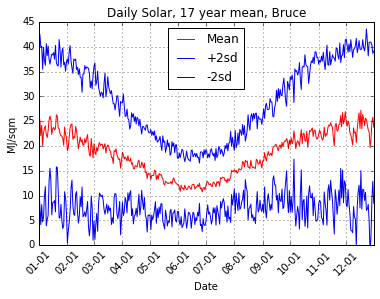

In [7]:
# Set up the month ticks for the x axis
daysInMonth = [31,29,31,30,31,30,31,31,30,31,30,31]
xticks = [sum(daysInMonth[0:i]) for i in range(len(daysInMonth))]

# Plot the data
ax = byYear.plot(y='Mean', 
                 title='Daily Solar, 17 year mean, Bruce',
                 legend=True,
                 style='r-',
                 xticks=xticks,
                 ylim=(0, 5*round(float(byYear['+2sd'].max())/5))
                )
byYear.plot(y='+2sd', 
            style='b-',
            ax=ax,
            grid=True
           )
byYear.plot(y='-2sd', 
            style='b-',
            ax=ax,
            grid=True
           )
ax.set_xlabel('Date')
ax.set_ylabel('MJ/sqm')
setp = plt.setp(ax.xaxis.get_majorticklabels(),rotation=45)

## Non-linear regression
The data is clearly a periodic function. We can use curve fitting methods (the most common implementation of which is least squares) from the scipy module to get the parameters of the periodic function.

In [8]:
# Define the function to be optimised
# This function will be passed to the curve fitter
def nonlinear_func(x, a, b, c, d):
    return a*np.sin(b*x + c) + d

When regressing, you must enter starting guesses for each of the parameters you wish to optimise. In this case, we can very easily approximate each parameter.

In [9]:
# Initial estimates of parameters for regression

# Amplitude ~ half of max - min
a_guess = (byYear['Mean'].max() - byYear['Mean'].min())/2.0
# B = 2pi / period. Period ~ 366 days
b_guess = 2*np.pi / 366
# Phase Shift = pi/2 (starts at a maximum)
c_guess = np.pi/2
# Equilibrium ~ average of max, min
d_guess = (byYear['Mean'].max() + byYear['Mean'].min())/2.0

print("Initial guesses:\nA: {}\nB: {}\nC: {}\nD: {}".format(a_guess, b_guess, c_guess, d_guess))

Initial guesses:
A: 8.236538461538462
B: 0.017167172970436028
C: 1.5707963267948966
D: 18.982692307692307


We now run the regression using the mean data.

In [10]:
# Perform the regression using scipy
xdata = np.arange(1, 367)
ydata = byYear['Mean'].as_matrix()
popt, pcov = curve_fit(nonlinear_func, xdata, ydata, p0=(a_guess, b_guess, c_guess, d_guess))
print("Optimised Values:\nA: {}\nB: {}\nC: {}\nD: {}".format(*popt))

Optimised Values:
A: 5.83234885435384
B: 0.018515944461279576
C: 1.6142849645453727
D: 18.096214800214636


## Evaluate Model
We can plot the models against each other in order to evaluate the goodness of fit.

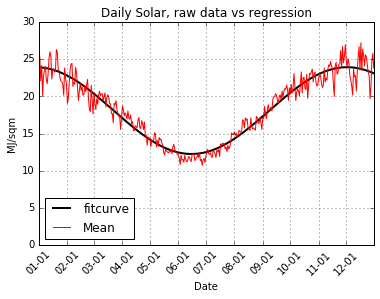

In [11]:
curvey = nonlinear_func(xdata, *popt)
byYear['fitcurve'] = curvey

# Plot the data

ax2 = byYear.plot(y='fitcurve', style='k-', linewidth=2)
byYear.plot(y='Mean',
            ax=ax2,
            title='Daily Solar, raw data vs regression',
            legend=True,
            grid=True,
            style='r-',
            xticks=xticks,
            ylim=(0, 5*ceil(float(byYear['Mean'].max())/5))
           )
ax2.set_xlabel('Date')
ax2.set_ylabel('MJ/sqm')
setp = plt.setp(ax2.xaxis.get_majorticklabels(),rotation=45)

The regression was successful. The fit is great.
The nature of the BOM data is such that (theoretically) this notebook can be used to analyse and regress any weather station's daily Global Solar Exposure.